In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import stats
#Single CHO cell dry mass: 280 pg/cell. Ref:https://doi.org/10.1016/j.ymben.2021.03.013
#Single mammalian cell dry mass: 264pg/cell. Ref: https://doi.org/10.1016/j.ymben.2020.06.002 

In [2]:
def add_linear(ax, xdata, ydata):
    def func(x, a, b):
        return a * x + b
    popt, pcov = curve_fit(func, xdata, ydata)
    temp_x = np.linspace(min(xdata),max(xdata) )
    ax.plot(temp_x, func(temp_x, *popt),'r--')
    
def get_pv(x,y):
    coeff, pv = stats.pearsonr( x, y)
    return pv

def get_pcc(x,y):
    coeff, pv = stats.pearsonr( x, y)
    return coeff

In [3]:
data_low=pd.read_csv('../data/exp_data/CultureData_lowNH4.csv')
data_low=data_low.rename(columns={'Biomass_avg(g/L)':'Biomass_avg','Biomass_std(g/L)':'Biomass_std'})
data_high=pd.read_csv('../data/exp_data/CultureData_highNH4.csv')
data_high=data_high.rename(columns={'Biomass_avg(g/L)':'Biomass_avg','Biomass_std(g/L)':'Biomass_std'})

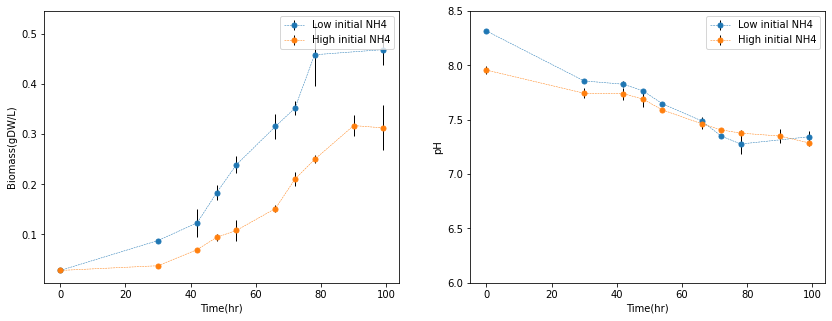

In [4]:
fig,axs=plt.subplots(1,2,figsize=(14,5))
axs[0].errorbar(data_low.Time,data_low.Biomass_avg,yerr= data_low.Biomass_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Low initial NH4')
axs[0].errorbar(data_high.Time,data_high.Biomass_avg,yerr= data_high.Biomass_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='High initial NH4')
axs[0].set_ylabel('Biomass(gDW/L)')
axs[1].errorbar(data_low.Time,data_low.pH_avg,yerr= data_low.pH_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Low initial NH4')
axs[1].errorbar(data_high.Time, data_high.pH_avg,yerr= data_high.pH_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='High initial NH4')
axs[1].set_ylim([6,8.5])
axs[1].set_ylabel('pH')
for ax in axs:
    ax.legend()
    ax.set_xlabel('Time(hr)')

Text(0, 0.5, 'Concentration (mM)')

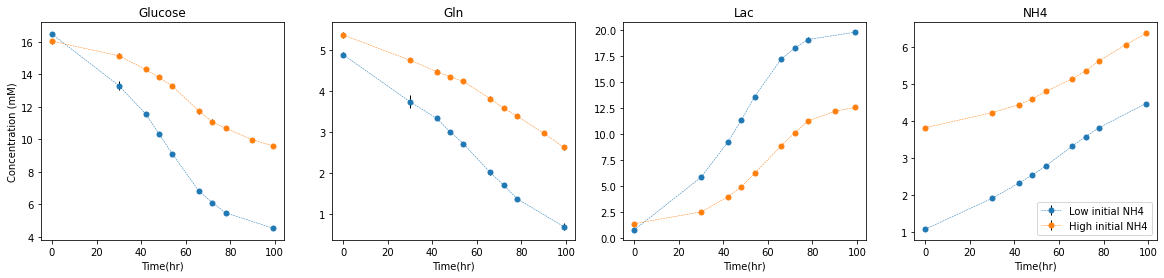

In [5]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
ynames=['Glucose','Gln','Lac','NH4']
for i in range(4):
    axs[i].errorbar(data_low.Time,data_low[ynames[i]+'_avg'],yerr= data_low[ynames[i]+'_std'], ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Low initial NH4')
    axs[i].errorbar(data_high.Time,data_high[ynames[i]+'_avg'],yerr= data_high[ynames[i]+'_std'], ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='High initial NH4')
    axs[i].set_xlabel('Time(hr)')
    axs[i].set_title(ynames[i])
axs[3].legend(loc='lower right')
axs[0].set_ylabel('Concentration (mM)')

In [6]:
def get_grs(biomass, time_pts):
    output = []
    for i in range(len(biomass)-1):
        output.append( np.log(biomass[i+1]/biomass[i]) /(time_pts[i+1]-time_pts[i]) )
    return output  
def avg_cons(cons):
    output = []
    for i in range(len(cons)-1):
        output.append( (cons[i+1]+cons[i])/2 )
    return output
def norm_rates(biomass, cons, time_pts):
    output = []
    for i in range(len(biomass)-1):
        output.append( ((cons[i+1]-cons[i])/(biomass[i]/2+biomass[i+1]/2) )/(time_pts[i+1]-time_pts[i]) )
    return output

In [7]:
mets=['Glucose','Gln','Lac','NH4']
Ts= [data_low.Time[i]/2+data_low.Time[i+1]/2 for i in range(len(data_low.Time)-1)]
grs=get_grs(data_low.Biomass_avg, data_low.Time)
approx_low = pd.DataFrame(zip(Ts,grs),columns=['Time','gr'])
for met in mets:
    approx_low[met+'_rate']=norm_rates( data_low.Biomass_avg, data_low[met+'_avg'], data_low.Time)
    approx_low[met+'_conc']=avg_cons( data_low[met+'_avg'] )
Ts=[data_high.Time[i]/2+data_high.Time[i+1]/2 for i in range(len(data_high.Time)-1)]
grs=get_grs(data_high.Biomass_avg, data_high.Time)
approx_high = pd.DataFrame(zip(Ts,grs),columns=['Time','gr'])
for met in mets:
    approx_high[met+'_rate']=norm_rates( data_high.Biomass_avg, data_high[met+'_avg'], data_high.Time)
    approx_high[met+'_conc']=avg_cons( data_high[met+'_avg'] )

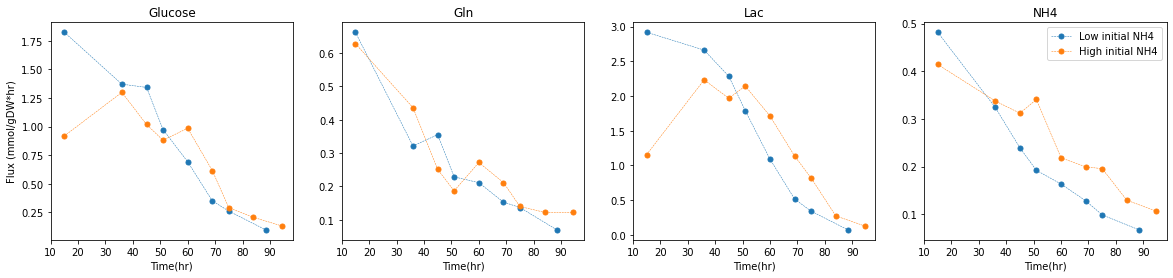

In [8]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
ynames=['Glucose','Gln','Lac','NH4']
for i in range(4):
    if i <2:
        factor=-1
    else:
        factor=1
    axs[i].plot(approx_low.Time, factor*approx_low[ynames[i]+'_rate'],marker='o', markersize=5, 
                linestyle='--', linewidth=0.5,label='Low initial NH4')
    axs[i].plot(approx_high.Time, factor*approx_high[ynames[i]+'_rate'],marker='o', markersize=5, 
                linestyle='--', linewidth=0.5,label='High initial NH4')
    axs[i].set_xlabel('Time(hr)')
    axs[i].set_xticks(np.arange(10,100,10))
    axs[i].set_title(ynames[i])
axs[0].set_ylabel('Flux (mmol/gDW*hr)')
axs[3].legend(loc='upper right')

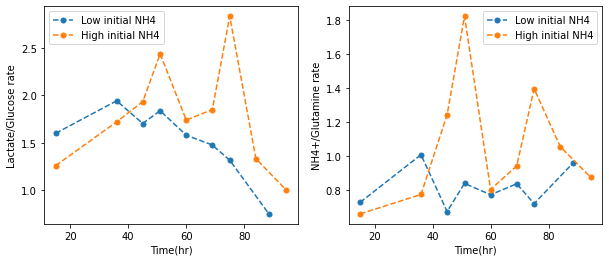

In [9]:
fig,axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(approx_low.Time,-1*approx_low.Lac_rate/approx_low.Glucose_rate,marker='o', 
            markersize=5, linestyle='--',label='Low initial NH4')
axs[0].plot(approx_high.Time,-1*approx_high.Lac_rate/approx_high.Glucose_rate,marker='o', 
            markersize=5, linestyle='--',label='High initial NH4')
axs[0].set_ylabel('Lactate/Glucose rate')
axs[1].plot(approx_low.Time,-1*approx_low.NH4_rate/approx_low.Gln_rate,marker='o', 
            markersize=5, linestyle='--',label='Low initial NH4')
axs[1].plot(approx_high.Time,-1*approx_high.NH4_rate/approx_high.Gln_rate,marker='o', 
            markersize=5, linestyle='--',label='High initial NH4')
axs[1].set_ylabel('NH4+/Glutamine rate')
for ax in axs:
    ax.set_xlabel('Time(hr)')
    ax.legend()

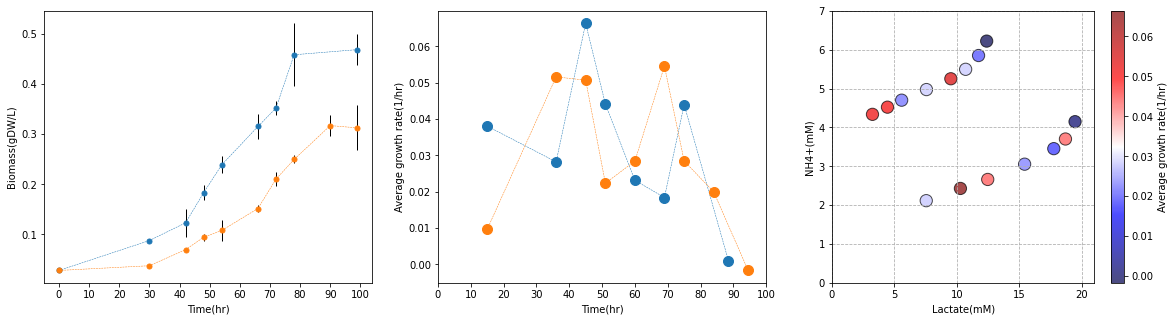

In [10]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs[0].errorbar(data_low.Time,data_low.Biomass_avg,yerr= data_low.Biomass_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Low initial NH4')
axs[0].errorbar(data_high.Time,data_high.Biomass_avg,yerr= data_high.Biomass_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='High initial NH4')
axs[0].set_ylabel('Biomass(gDW/L)')
axs[1].plot(approx_low.Time,approx_low.gr,marker='o', markersize=10, linestyle='--', 
            linewidth=0.5, label='Low initial NH4')
axs[1].plot(approx_high.Time,approx_high.gr,marker='o', markersize=10, linestyle='--', 
            linewidth=0.5,label='High initial NH4')
axs[1].set_ylabel('Average growth rate(1/hr)')
grs = list(approx_low['gr'])[1:]+list(approx_high['gr'])[1:]
pt1=axs[2].scatter( list(approx_low['Lac_conc'])[1:]+list(approx_high['Lac_conc'])[1:], 
                   list(approx_low['NH4_conc'])[1:]+list(approx_high['NH4_conc'])[1:], c=grs, 
                   cmap='seismic',alpha=0.7,s=150, edgecolor='black')
plt.colorbar(pt1, label='Average growth rate(1/hr)')
axs[2].set_xlabel('Lactate(mM)'); axs[2].set_ylabel('NH4+(mM)')
axs[2].grid(ls='--'); axs[2].set_xlim([0,21.0]); axs[2].set_ylim([0,7.0]);
for ax in axs[:2]:
    ax.set_xlabel('Time(hr)')
    ax.set_xticks(np.arange(0,110,10))

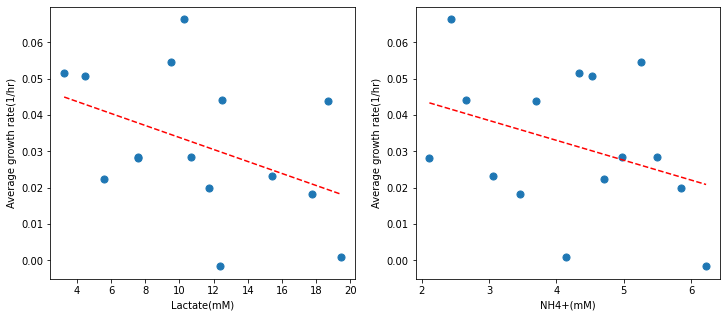

In [11]:
fig,axs=plt.subplots(1,2,figsize=(12,5))
grs = list(approx_low['gr'])[1:]+list(approx_high['gr'])[1:]
axs[0].scatter(list(approx_low['Lac_conc'])[1:]+list(approx_high['Lac_conc'])[1:],grs,marker='o', s=50)
add_linear(axs[0], list(approx_low['Lac_conc'])[1:]+list(approx_high['Lac_conc'])[1:],grs)
axs[1].scatter(list(approx_low['NH4_conc'])[1:]+list(approx_high['NH4_conc'])[1:],grs,marker='o', s=50)
add_linear(axs[1], list(approx_low['NH4_conc'])[1:]+list(approx_high['NH4_conc'])[1:],grs)
for ax in axs:
    ax.set_ylabel('Average growth rate(1/hr)')
axs[0].set_xlabel('Lactate(mM)'); axs[1].set_xlabel('NH4+(mM)');

In [13]:
ATP_approx_low, ATP_approx_high=[],[]
for i in range(len(approx_low.index)):
    lac_r=approx_low.Lac_rate[i];glc_r=(-1)*approx_low.Glucose_rate[i];gln_r=(-1)*approx_low.Gln_rate[i];
    ATP_approx_low.append( lac_r + max(0,(glc_r-lac_r/2))*30 + gln_r*22.5 )
for i in range(len(approx_high.index)):
    lac_r=approx_high.Lac_rate[i];glc_r=(-1)*approx_high.Glucose_rate[i];gln_r=(-1)*approx_high.Gln_rate[i];
    ATP_approx_high.append( lac_r + max(0,(glc_r-lac_r/2))*30 + gln_r*22.5 )
    
approx_low['ATP_estimated']=ATP_approx_low
approx_high['ATP_estimated']=ATP_approx_high

In [40]:
approx_low

,Time,gr,Glucose_rate,Glucose_conc,Gln_rate,Gln_conc,Lac_rate,Lac_conc,NH4_rate,NH4_conc,ATP_estimated
0,15.0,0.038070,-1.824117,14.883333,-0.662442,4.315000,2.918587,3.333333,0.481951,1.491667,28.768241
1,36.0,0.028229,-1.370181,12.433333,-0.321465,3.536667,2.661312,7.550000,0.324100,2.115000,11.080018
2,45.0,0.066352,-1.341688,10.950000,-0.355366,3.170000,2.284496,10.283333,0.239328,2.430000,16.263435
3,51.0,0.044171,-0.973643,9.716667,-0.228938,2.861667,1.789398,12.466667,0.192097,2.661667,9.308818
4,60.0,0.023156,-0.691438,7.950000,-0.211440,2.365000,1.092272,15.416667,0.163340,3.055000,10.208734
5,69.0,0.018421,-0.349406,6.450000,-0.153073,1.860000,0.515790,17.750000,0.128116,3.455000,6.705268
6,75.0,0.043982,-0.260288,5.783333,-0.136994,1.540000,0.342485,18.683333,0.098636,3.703333,6.096224
7,88.5,0.001054,-0.095813,5.000000,-0.069807,1.033333,0.071860,19.450000,0.067069,4.150000,3.439001


In [42]:
temp_grs = list(approx_low.gr[1:5]) + list(approx_high.gr[1:5])
temp_atp = list(approx_low.ATP_estimated[1:5]) + list(approx_high.ATP_estimated[1:5])
def func(x, a, b):
    return a * x + b
popt, pcov = curve_fit(func, temp_grs, temp_atp)
print(popt)

[148.00260846   5.55051952]


In [43]:
temp_grs = list(approx_low.gr[5:]) + list(approx_high.gr[5:])
temp_atp = list(approx_low.ATP_estimated[5:]) + list(approx_high.ATP_estimated[5:])
def func(x, a, b):
    return a * x + b
popt, pcov = curve_fit(func, temp_grs, temp_atp)
print(popt)

[45.90084134  4.26184254]


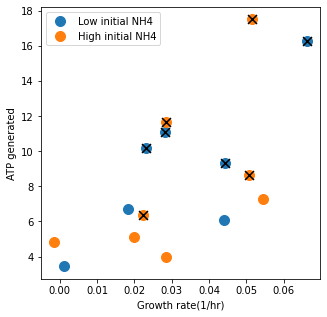

In [44]:
temp_grs = list(approx_low.gr[1:5]) + list(approx_high.gr[1:5])
temp_atp = list(approx_low.ATP_estimated[1:5]) + list(approx_high.ATP_estimated[1:5])
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(approx_low.gr[1:],approx_low.ATP_estimated[1:],s=100,label='Low initial NH4')
ax.scatter(approx_high.gr[1:],approx_high.ATP_estimated[1:],s=100,label='High initial NH4')
ax.scatter(temp_grs, temp_atp,s=80,marker='x',color='black')
ax.set_ylabel('ATP generated')
ax.set_xlabel('Growth rate(1/hr)')

# temp_x = np.linspace(0.01,0.07)
# ax.plot(temp_x, func(temp_x, *popt),'r--')
# y_pred = [func(x, 148.0, 5.55) for x in temp_grs]
# print( get_pcc(temp_atp,y_pred) )
ax.legend();

In [36]:
temp_grs = list(approx_low.gr)[5:]+list(approx_high.gr)[5:]
temp_atp = list(approx_low.ATP_estimated)[5:]+list(approx_high.ATP_estimated)[5:]
temp_lac = list(approx_low.Lac_conc)[5:]+list(approx_high.Lac_conc)[5:]
temp_nh4 = list(approx_low.NH4_conc)[5:]+list(approx_high.NH4_conc)[5:]
ngam = [temp_atp[i]-148*temp_grs[i] for i in range(len(temp_grs))]

In [37]:
ngam

[3.978992434466294,
 -0.4130960106671804,
 3.283011465084055,
 -0.8024463000771718,
 -0.24077348266149778,
 2.129838953036922,
 5.064319511686482]